In [1]:
import spicy_snow
import xarray as xr
import pathlib
import pandas as pd
import rioxarray
import datetime
import numpy as np
import matplotlib.pyplot as plt
import contextily
import tqdm

# Setup
```
conda install -y -c conda-forge dask geopandas rioxarray matplotlib netcdf4 pandas zarr earthaccess pygeohydro hyp3_sdk ipywidgets
pip install asf_search
```

# Get File list

In [2]:
spicy_snow.__file__

'/home/griessban/.conda/envs/spicy314/lib/python3.14/site-packages/spicy_snow/__init__.py'

In [16]:
import geopandas

region = 'LBNL'
rois = geopandas.read_file('/data/shapes/tristate_rois.gpkg')
roi = rois.loc[rois.name==region]
bounds = roi.geometry.iloc[0].bounds

In [17]:
import datetime
start = datetime.datetime.strptime('2025-05-01', '%Y-%m-%d')
end = datetime.datetime.strptime('2025-09-28', '%Y-%m-%d')
dates = [start, end]

In [18]:
work_dir = pathlib.Path('/scratch/spicy_data/')

In [19]:
s1_urls = spicy_snow.find_data.get_sentinel1_urls(start_date=start, stop_date=end, aoi=bounds)

/tmp/ipykernel_3020732/3905244030.py:1: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguous
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  s1_urls = spicy_snow.find_data.get_sentinel1_urls(start_date=start, stop_date=end, aoi=bounds)


In [20]:
s1_fps = spicy_snow.utils.download.download_urls_parallel(s1_urls, work_dir.joinpath('opera'))

Downloading:   0%|          | 0/3258 [00:00<?, ?it/s]

# Do master grid

- We want to clip all the S1 tiles to the grid of the fSCA.
- The fSCA is at 10 m, S1 tiles are at 30 m
- The origins of fsca and the das might differ

Approach:

- get bounds from fsac
- get set of all coordinates
- make a da from these coordinates
- clip this da to fsca bounds

In [21]:
fsca = xr.open_zarr(f'/data/sentinel2/zarrs_v3/{region}_postprocessed.zarr/')['fsca_treefilled']
grid10 = fsca.isel(time=0)

In [22]:
pol = 'vh'
pol_fps = [f for f in s1_fps if f.stem.lower().endswith(pol)]

xs = []
ys = []
for fp in tqdm.tqdm(pol_fps):
    da = rioxarray.open_rasterio(fp, chunks={'x':-1,  'y': -1})
    if da.rio.crs == grid10.rio.crs:
        xs.append(da.x.values)
        ys.append(da.y.values)
all_x = np.unique(np.concatenate(xs))
all_y = np.unique(np.concatenate(ys))

100%|██████████| 1086/1086 [00:10<00:00, 99.20it/s]


In [23]:
grid30 = xr.DataArray(
    np.ones((len(all_y), len(all_x))),
    coords={"y": sorted(all_y)[::-1], "x": sorted(all_x)},
    dims=("y", "x"),
)
grid30 = grid30.rio.write_crs(grid10.rio.crs)
grid30 = grid30.rio.clip_box(*grid10.rio.bounds())

In [26]:
%%time
watermask = rioxarray.open_rasterio('/data/watermask/landWater2020_-150_030.tif', chunks='auto', mask_and_scale=True).squeeze()
watermask = watermask.drop_vars('band')
watermask = watermask.rio.clip_box(*bounds)

CPU times: user 124 ms, sys: 3.09 ms, total: 128 ms
Wall time: 149 ms


In [27]:
watermask = watermask.rio.reproject_match(grid30)

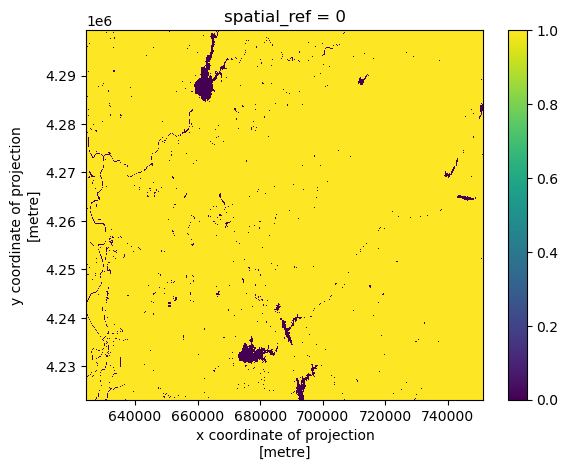

In [28]:
watermask.plot()